In [1]:
import torch
torch.manual_seed(123)
import random
random.seed(123)

import torch.nn as nn
import os
import shutil
import itertools
import sklearn.cluster

from chofer_torchex.utils.data.collate import dict_sample_target_iter_concat
from chofer_torchex.utils.functional import collection_cascade, cuda_cascade

from chofer_tda_datasets import Reininghaus2014ShrecReal
from chofer_tda_datasets.transforms import Hdf5GroupToDict

from jmlr_2018_code.utils import *
from chofer_torchex.nn.slayer import SLayerExponential, \
SLayerRational, \
LinearRationalStretchedBirthLifeTimeCoordinateTransform, \
prepare_batch, SLayerRationalHat
from sklearn.model_selection import ShuffleSplit
from collections import Counter, defaultdict
from torch.utils.data import DataLoader
from collections import OrderedDict
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit


%matplotlib notebook
%load_ext autoreload
%autoreload 2

os.environ['CUDA_VISIBLE_DEVICES'] = str(0)


class train_env:
    nu = 0.01
    n_epochs = 300
    lr_initial = 0.5
    momentum = 0.9
    lr_epoch_step = 20
    batch_size = 20
    train_size = 0.9
    minimal_distance_from_diagonal = 0.00001
    

coordinate_transform = LinearRationalStretchedBirthLifeTimeCoordinateTransform(nu=train_env.nu)

def filter_out_diagonal_points(x):
    def fn(dgm):
        i = ((dgm[:, 1] - dgm[:, 0]) > train_env.minimal_distance_from_diagonal).nonzero().squeeze()
        if len(i) == 0:
            return torch.Tensor([])
        else:             
            return dgm[i]
    
    
    return collection_cascade(x, lambda xx: isinstance(xx, torch._TensorBase), fn)


dataset = Reininghaus2014ShrecReal(data_root_folder_path='/scratch1/chofer/jmlr2018_data/')
dataset.data_transforms = [
                           Hdf5GroupToDict(),
                           numpy_to_torch_cascade,   
                           filter_out_diagonal_points,
                           lambda x: collection_cascade(x, 
                                                        lambda x: isinstance(x, torch._TensorBase), 
                                                        lambda x: coordinate_transform(x)),
                           ]

dataset.target_transforms = [lambda x: int(x)]

/scratch2/chofer/opt/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def concat_shrec_sample_target_iter(sample_target_iter):
    x, y = defaultdict(lambda: defaultdict(list)), []
        
    for x_i, y_i in sample_target_iter:
        y.append(y_i)

        for k, v in x_i.items():
            for kk, dgm in v.items():
                x[k][kk].append(dgm)    

    return x, y


class ShrecCollate:   
    def __init__(self, cuda=True):
        self.cuda = cuda
        
    def __call__(self, sample_target_iter):
        x, y = concat_shrec_sample_target_iter(sample_target_iter)

        y = torch.LongTensor(y)    
        
        x = collection_cascade(x,
                           lambda xx: isinstance(xx, list),
                           lambda xx: prepare_batch(xx, 2)) 
        
        if self.cuda:
            # Shifting the necessary parts of the prepared batch to the cuda
            x = collection_cascade(x,
                                   lambda xx: isinstance(xx, tuple),
                                  lambda xx: (xx[0].cuda(), xx[1].cuda(), xx[2], xx[3]))
            y = y.cuda()

        return x, y                       
    
collate_fn = ShrecCollate(cuda=True)

In [3]:
def Slayer(n_elements):
    return SLayerRationalHat(n_elements, radius_init=50, exponent=1)

def LinearCell(n_in, n_out):
    m = nn.Sequential(nn.Linear(n_in, n_out), 
                      nn.BatchNorm1d(n_out), 
                      nn.ReLU(),
                     )
    m.out_features = m[0].out_features
    return m


class ShrecRealModel(nn.Module):
    def __init__(self):
        super().__init__()   
        self.n_elements = 40
        
        self.slayers = ModuleDict()
        for k in (str(i) for i in range(1, 11)):
            self.slayers[k] = ModuleDict()
            for kk in (str(i) for i in range(2)):
                s = Slayer(self.n_elements)
                self.slayers[k][kk] = nn.Sequential(s, 
                                                    nn.BatchNorm1d(self.n_elements)
                                                   )      
            
        cls_in_dim = self.n_elements * 10 * 2
        self.cls = nn.Sequential(
#                                 nn.Dropout(0.05),
                                LinearCell(cls_in_dim, cls_in_dim),    
#                                 nn.Dropout(0.2),
                                LinearCell(cls_in_dim, int(cls_in_dim/4)),  
#                                 nn.Dropout(0.1),
                                nn.Linear(int(cls_in_dim/4), 40))
        
    def forward(self, input):
        x = []
        for k, v in input.items():
            for kk, dgm in v.items():            
                x.append(self.slayers[k][kk](dgm))
        x = torch.cat(x, dim=1)          
        x = self.cls(x)       
                                              
        return x
    
    def center_init(self, sample_target_iter):
        x, _ = concat_shrec_sample_target_iter(sample_target_iter)
        
        x = collection_cascade(x, stop_predicate=lambda e: isinstance(e, list), 
                                  function_to_apply=lambda e: torch.cat(e, dim=0).numpy())        
        
        for k, v in x.items():
            for kk, dgm in v.items():                  
                kmeans = sklearn.cluster.KMeans(n_clusters=self.n_elements, init='k-means++', random_state=123)
                try:                    
                    kmeans.fit(dgm)
                except Exception as ex:
                    print(dgm)
                    raise ex
                centers = kmeans.cluster_centers_
                centers = torch.from_numpy(centers)
                self.slayers[k][kk][0].centers.data = centers
            
            

In [4]:
stats_of_runs = []
def experiment():   
    
    splitter = StratifiedShuffleSplit(n_splits=10, 
                                      train_size=train_env.train_size, 
                                      test_size=1-train_env.train_size, 
                                      random_state=123)
    train_test_splits = list(splitter.split(X=dataset.targets, y=dataset.targets))
    train_test_splits = [(train_i.tolist(), test_i.tolist()) for train_i, test_i in train_test_splits]
    
    for run_i, (train_i, test_i) in enumerate(train_test_splits):
        print('')
        print('Run', run_i)     

        model = ShrecRealModel()
        model.center_init([dataset[i] for i in train_i])
        model.cuda()

        stats = defaultdict(list)
        stats_of_runs.append(stats)
        
        opt = torch.optim.SGD(model.parameters(), lr=train_env.lr_initial, momentum=train_env.momentum)

        for i_epoch in range(1, train_env.n_epochs+1):      

            model.train()
            
            train_sampler = [i for i in train_i]
            random.shuffle(train_sampler)
            dl_train = DataLoader(dataset,
                                  batch_size=train_env.batch_size, 
                                  collate_fn=collate_fn,
                                  sampler=train_sampler)

            dl_test = DataLoader(dataset,
                                 batch_size=train_env.batch_size, 
                                 collate_fn=collate_fn, 
                                 sampler=test_i)

            epoch_loss = 0    

            if i_epoch % train_env.lr_epoch_step == 0:
                adapt_lr(opt, lambda lr: lr*0.5)

            for i_batch, (x, y) in enumerate(dl_train, 1):              

                y = torch.autograd.Variable(y)

                def closure():
                    opt.zero_grad()
                    y_hat = model(x)            
                    loss = nn.functional.cross_entropy(y_hat, y)   
                    loss.backward()
                    return loss

                loss = opt.step(closure)

                epoch_loss += float(loss)
                stats['loss_by_batch'].append(float(loss))
                stats['centers'].append(model.slayers['1']['0'][0].centers.data.cpu().numpy())

                print("Epoch {}/{}, Batch {}/{}".format(i_epoch, train_env.n_epochs, i_batch, len(dl_train)), end="       \r")

            stats['train_loss_by_epoch'].append(epoch_loss/len(dl_train))            
                     
            model.eval()    
            true_samples = 0
            seen_samples = 0
            epoch_test_loss = 0
            for i_batch, (x, y) in enumerate(dl_test):

                y_hat = model(x)
                epoch_test_loss += float(nn.functional.cross_entropy(y_hat, torch.autograd.Variable(y.cuda())).data)

                y_hat = y_hat.max(dim=1)[1].data.long()

                true_samples += (y_hat == y).sum()
                seen_samples += y.size(0)  

            stats['test_accuracy'].append(true_samples/seen_samples)
            stats['test_loss_by_epoch'].append(epoch_test_loss/len(dl_test))
            print('')
            print(true_samples/seen_samples)
            
        print('')
        print('acc.', np.mean(stats['test_accuracy'][-10:]))
#     return stats_of_runs

experiment()
# stats_of_runs = experiment()


Run 0
Epoch 1/300, Batch 18/18       
0.075
Epoch 2/300, Batch 18/18       
0.3
Epoch 3/300, Batch 18/18       
0.325
Epoch 4/300, Batch 18/18       
0.25
Epoch 5/300, Batch 18/18       
0.325
Epoch 6/300, Batch 18/18       
0.325
Epoch 7/300, Batch 18/18       
0.35
Epoch 8/300, Batch 18/18       
0.325
Epoch 9/300, Batch 18/18       
0.225
Epoch 10/300, Batch 18/18       
0.275
Epoch 11/300, Batch 18/18       
0.4
Epoch 12/300, Batch 18/18       
0.15
Epoch 13/300, Batch 18/18       
0.225
Epoch 14/300, Batch 18/18       
0.175
Epoch 15/300, Batch 18/18       
0.225
Epoch 16/300, Batch 18/18       
0.225
Epoch 17/300, Batch 18/18       
0.275
Epoch 18/300, Batch 18/18       
0.075
Epoch 19/300, Batch 18/18       
0.125
Epoch 20/300, Batch 18/18       
0.175
Epoch 21/300, Batch 18/18       
0.225
Epoch 22/300, Batch 18/18       
0.3
Epoch 23/300, Batch 18/18       
0.175
Epoch 24/300, Batch 18/18       
0.225
Epoch 25/300, Batch 18/18       
0.325
Epoch 26/300, Batch 18/18       
0.2

Epoch 120/300, Batch 18/18       
0.65
Epoch 121/300, Batch 18/18       
0.675
Epoch 122/300, Batch 18/18       
0.675
Epoch 123/300, Batch 18/18       
0.65
Epoch 124/300, Batch 18/18       
0.625
Epoch 125/300, Batch 18/18       
0.65
Epoch 126/300, Batch 18/18       
0.65
Epoch 127/300, Batch 18/18       
0.675
Epoch 128/300, Batch 18/18       
0.65
Epoch 129/300, Batch 18/18       
0.625
Epoch 130/300, Batch 18/18       
0.6
Epoch 131/300, Batch 18/18       
0.625
Epoch 132/300, Batch 18/18       
0.65
Epoch 133/300, Batch 18/18       
0.65
Epoch 134/300, Batch 18/18       
0.65
Epoch 135/300, Batch 18/18       
0.65
Epoch 136/300, Batch 18/18       
0.625
Epoch 137/300, Batch 18/18       
0.625
Epoch 138/300, Batch 18/18       
0.625
Epoch 139/300, Batch 18/18       
0.675
Epoch 140/300, Batch 18/18       
0.675
Epoch 141/300, Batch 18/18       
0.65
Epoch 142/300, Batch 18/18       
0.65
Epoch 143/300, Batch 18/18       
0.65
Epoch 144/300, Batch 18/18       
0.625
Epoch 145/300,

Epoch 237/300, Batch 18/18       
0.625
Epoch 238/300, Batch 18/18       
0.7
Epoch 239/300, Batch 18/18       
0.65
Epoch 240/300, Batch 18/18       
0.675
Epoch 241/300, Batch 18/18       
0.625
Epoch 242/300, Batch 18/18       
0.675
Epoch 243/300, Batch 18/18       
0.6
Epoch 244/300, Batch 18/18       
0.575
Epoch 245/300, Batch 18/18       
0.625
Epoch 246/300, Batch 18/18       
0.65
Epoch 247/300, Batch 18/18       
0.625
Epoch 248/300, Batch 18/18       
0.525
Epoch 249/300, Batch 18/18       
0.6
Epoch 250/300, Batch 18/18       
0.625
Epoch 251/300, Batch 18/18       
0.575
Epoch 252/300, Batch 18/18       
0.575
Epoch 253/300, Batch 18/18       
0.55
Epoch 254/300, Batch 18/18       
0.55
Epoch 255/300, Batch 18/18       
0.55
Epoch 256/300, Batch 18/18       
0.625
Epoch 257/300, Batch 18/18       
0.625
Epoch 258/300, Batch 18/18       
0.6
Epoch 259/300, Batch 18/18       
0.625
Epoch 260/300, Batch 18/18       
0.625
Epoch 261/300, Batch 18/18       
0.625
Epoch 262/300

Epoch 57/300, Batch 18/18       
0.625
Epoch 58/300, Batch 18/18       
0.15
Epoch 59/300, Batch 18/18       
0.575
Epoch 60/300, Batch 18/18       
0.7
Epoch 61/300, Batch 18/18       
0.7
Epoch 62/300, Batch 18/18       
0.75
Epoch 63/300, Batch 18/18       
0.65
Epoch 64/300, Batch 18/18       
0.65
Epoch 65/300, Batch 18/18       
0.7
Epoch 66/300, Batch 18/18       
0.575
Epoch 67/300, Batch 18/18       
0.65
Epoch 68/300, Batch 18/18       
0.625
Epoch 69/300, Batch 18/18       
0.675
Epoch 70/300, Batch 18/18       
0.7
Epoch 71/300, Batch 18/18       
0.625
Epoch 72/300, Batch 18/18       
0.725
Epoch 73/300, Batch 18/18       
0.675
Epoch 74/300, Batch 18/18       
0.7
Epoch 75/300, Batch 18/18       
0.675
Epoch 76/300, Batch 18/18       
0.675
Epoch 77/300, Batch 18/18       
0.65
Epoch 78/300, Batch 18/18       
0.65
Epoch 79/300, Batch 18/18       
0.425
Epoch 80/300, Batch 18/18       
0.6
Epoch 81/300, Batch 18/18       
0.625
Epoch 82/300, Batch 18/18       
0.675
Epoch

Epoch 176/300, Batch 18/18       
0.75
Epoch 177/300, Batch 18/18       
0.775
Epoch 178/300, Batch 18/18       
0.775
Epoch 179/300, Batch 18/18       
0.75
Epoch 180/300, Batch 18/18       
0.75
Epoch 181/300, Batch 18/18       
0.75
Epoch 182/300, Batch 18/18       
0.725
Epoch 183/300, Batch 18/18       
0.725
Epoch 184/300, Batch 18/18       
0.75
Epoch 185/300, Batch 18/18       
0.75
Epoch 186/300, Batch 18/18       
0.75
Epoch 187/300, Batch 18/18       
0.725
Epoch 188/300, Batch 18/18       
0.75
Epoch 189/300, Batch 18/18       
0.75
Epoch 190/300, Batch 18/18       
0.75
Epoch 191/300, Batch 18/18       
0.725
Epoch 192/300, Batch 18/18       
0.75
Epoch 193/300, Batch 18/18       
0.75
Epoch 194/300, Batch 18/18       
0.75
Epoch 195/300, Batch 18/18       
0.75
Epoch 196/300, Batch 18/18       
0.75
Epoch 197/300, Batch 18/18       
0.75
Epoch 198/300, Batch 18/18       
0.75
Epoch 199/300, Batch 18/18       
0.75
Epoch 200/300, Batch 18/18       
0.725
Epoch 201/300, Bat

Epoch 297/300, Batch 18/18       
0.6
Epoch 298/300, Batch 18/18       
0.6
Epoch 299/300, Batch 18/18       
0.6
Epoch 300/300, Batch 18/18       
0.6

acc. 0.6049999999999999

Run 7
Epoch 1/300, Batch 18/18       
0.15
Epoch 2/300, Batch 18/18       
0.3
Epoch 3/300, Batch 18/18       
0.225
Epoch 4/300, Batch 18/18       
0.275
Epoch 5/300, Batch 18/18       
0.25
Epoch 6/300, Batch 18/18       
0.275
Epoch 7/300, Batch 18/18       
0.275
Epoch 8/300, Batch 18/18       
0.45
Epoch 9/300, Batch 18/18       
0.325
Epoch 10/300, Batch 18/18       
0.25
Epoch 11/300, Batch 18/18       
0.35
Epoch 12/300, Batch 18/18       
0.225
Epoch 13/300, Batch 18/18       
0.275
Epoch 14/300, Batch 18/18       
0.1
Epoch 15/300, Batch 18/18       
0.025
Epoch 16/300, Batch 18/18       
0.05
Epoch 17/300, Batch 18/18       
0.125
Epoch 18/300, Batch 18/18       
0.15
Epoch 19/300, Batch 18/18       
0.15
Epoch 20/300, Batch 18/18       
0.325
Epoch 21/300, Batch 18/18       
0.325
Epoch 22/300, Batc

Epoch 119/300, Batch 18/18       
0.775
Epoch 120/300, Batch 18/18       
0.8
Epoch 121/300, Batch 18/18       
0.75
Epoch 122/300, Batch 18/18       
0.75
Epoch 123/300, Batch 18/18       
0.825
Epoch 124/300, Batch 18/18       
0.775
Epoch 125/300, Batch 18/18       
0.75
Epoch 126/300, Batch 18/18       
0.8
Epoch 127/300, Batch 18/18       
0.8
Epoch 128/300, Batch 18/18       
0.725
Epoch 129/300, Batch 18/18       
0.775
Epoch 130/300, Batch 18/18       
0.75
Epoch 131/300, Batch 18/18       
0.75
Epoch 132/300, Batch 18/18       
0.8
Epoch 133/300, Batch 18/18       
0.75
Epoch 134/300, Batch 18/18       
0.725
Epoch 135/300, Batch 18/18       
0.75
Epoch 136/300, Batch 18/18       
0.775
Epoch 137/300, Batch 18/18       
0.8
Epoch 138/300, Batch 18/18       
0.8
Epoch 139/300, Batch 18/18       
0.725
Epoch 140/300, Batch 18/18       
0.8
Epoch 141/300, Batch 18/18       
0.775
Epoch 142/300, Batch 18/18       
0.775
Epoch 143/300, Batch 18/18       
0.75
Epoch 144/300, Batch 1

Epoch 29/300, Batch 18/18       
0.325
Epoch 30/300, Batch 18/18       
0.5
Epoch 31/300, Batch 18/18       
0.325
Epoch 32/300, Batch 18/18       
0.325
Epoch 33/300, Batch 18/18       
0.325
Epoch 34/300, Batch 18/18       
0.425
Epoch 35/300, Batch 18/18       
0.375
Epoch 36/300, Batch 18/18       
0.525
Epoch 37/300, Batch 18/18       
0.175
Epoch 38/300, Batch 18/18       
0.475
Epoch 39/300, Batch 18/18       
0.175
Epoch 40/300, Batch 18/18       
0.45
Epoch 41/300, Batch 18/18       
0.325
Epoch 42/300, Batch 18/18       
0.625
Epoch 43/300, Batch 18/18       
0.575
Epoch 44/300, Batch 18/18       
0.55
Epoch 45/300, Batch 18/18       
0.5
Epoch 46/300, Batch 18/18       
0.525
Epoch 47/300, Batch 18/18       
0.6
Epoch 48/300, Batch 18/18       
0.5
Epoch 49/300, Batch 18/18       
0.425
Epoch 50/300, Batch 18/18       
0.55
Epoch 51/300, Batch 18/18       
0.5
Epoch 52/300, Batch 18/18       
0.375
Epoch 53/300, Batch 18/18       
0.5
Epoch 54/300, Batch 18/18       
0.35
Ep

In [9]:
last_10_runs = [np.mean(s['test_accuracy'][-10:]) for s in stats_of_runs]
print(np.mean(last_10_runs))
print(np.std(last_10_runs))
last_10_runs

0.71425
0.07826277850932718


[0.6725000000000001,
 0.6425000000000001,
 0.59,
 0.78,
 0.7274999999999999,
 0.73,
 0.6049999999999999,
 0.8225,
 0.7950000000000002,
 0.7775000000000001]

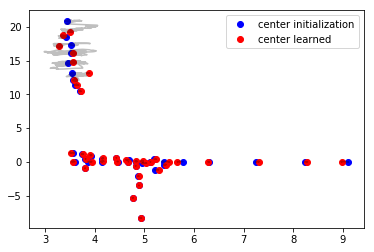

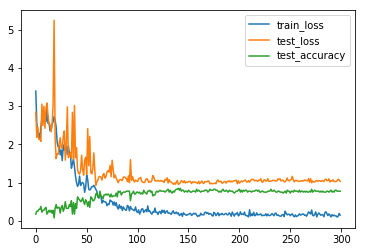

In [8]:

stats = stats_of_runs[-1]
plt.figure()

if 'centers' in stats:
    c_start = stats['centers'][0]
    c_end = stats['centers'][-1]

    plt.plot(c_start[:,0], c_start[:, 1], 'bo', label='center initialization')
    plt.plot(c_end[:,0], c_end[:, 1], 'ro', label='center learned')

    all_centers = numpy.stack(stats['centers'], axis=0)
    for i in range(all_centers.shape[1]):
        points = all_centers[:,i, :]
        plt.plot(points[:, 0], points[:, 1], '-k', alpha=0.25)
        

    plt.legend()
    
plt.figure()
plt.plot(stats['train_loss_by_epoch'], label='train_loss')
plt.plot(stats['test_loss_by_epoch'], label='test_loss')
plt.plot(stats['test_accuracy'], label='test_accuracy')


plt.legend()
plt.show()
